In [6]:
from io import IncrementalNewlineDecoder
import numpy as np
import matplotlib.pyplot
%matplotlib inline
import time
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [7]:
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

In [8]:
mnist_train_x = "/content/drive/MyDrive/MINIST/train-images.idx3-ubyte"
mnist_train_y = "/content/drive/MyDrive/MINIST/train-labels.idx1-ubyte"
mnist_test_x = "/content/drive/MyDrive/MINIST/t10k-images.idx3-ubyte"
mnist_test_y = "/content/drive/MyDrive/MINIST/t10k-labels.idx1-ubyte"


In [9]:
convert(mnist_train_x, mnist_train_y, "/content/drive/MyDrive/MINIST/train.csv", 60000)
convert(mnist_test_x, mnist_test_y, "/content/drive/MyDrive/MINIST/test.csv", 10000)

In [10]:
train_file = open("/content/drive/MyDrive/MINIST/train.csv", "r")
train_list = train_file.readlines()
train_file.close()
print(len(train_list))

60000


In [11]:
train_list[100]

'5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,18,46,136,136,244,255,241,103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,94,163,253,253,253,253,238,218,204,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,131,253,253,253,253,237,200,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,155,246,253,247,108,65,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,207,253,253,230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,157,253,253,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89,253,250,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89,253,247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89,253,247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89,253,247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

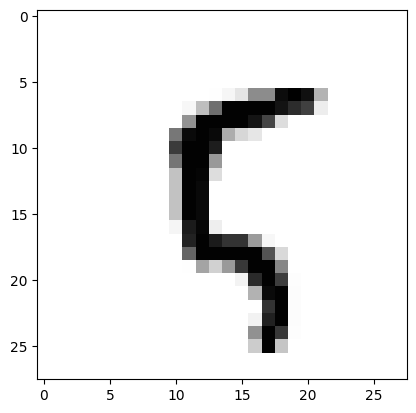

In [12]:
import numpy as np
import matplotlib.pyplot as plt

all_values = train_list[100].split(',')
image_array = np.asarray(all_values[1:], dtype=np.float32).reshape((28, 28))
plt.imshow(image_array, cmap='Greys', interpolation='none')
plt.show()

In [13]:
test_file = open("/content/drive/MyDrive/MINIST/test.csv", "r")
test_list = test_file.readlines()
test_file.close()
print(len(test_list))

10000


In [14]:
import numpy as np
import time
import matplotlib.pyplot as plt

class DNN:
    def __init__(self, sizes, epochs, lr):
        self.sizes = sizes
        self.epochs = epochs
        self.lr = lr

        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        self.params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x)) / ((np.exp(-x) + 1) ** 2)
        return 1 / (1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max(axis=-1, keepdims=True))  # Prevent overflow in exponentiation
        if derivative:
            softmax_out = exps / np.sum(exps, axis=-1, keepdims=True)
            return softmax_out * (1 - softmax_out)
        return exps / np.sum(exps, axis=-1, keepdims=True)

    def forward_pass(self, x_train):
        params = self.params
        params['A0'] = x_train

        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}

        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.lr * value

    def compute_accuracy(self, data_list, output_nodes):
        predictions = []

        for x in data_list:
            all_values = x.split(',')
            inputs = np.asarray(all_values[1:], dtype=np.float32) / 255.0 * 0.99 + 0.01
            targets = np.zeros(output_nodes) + 0.01
            targets[int(all_values[0])] = 0.99
            output = self.forward_pass(inputs)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(targets))

        return np.mean(predictions)

    def compute_loss(self, data_list, output_nodes):
        loss = 0

        for x in data_list:
            all_values = x.split(',')
            inputs = np.asarray(all_values[1:], dtype=np.float32) / 255.0 * 0.99 + 0.01
            targets = np.zeros(output_nodes) + 0.01
            targets[int(all_values[0])] = 0.99
            output = self.forward_pass(inputs)
            loss += -np.sum(targets * np.log(output + 1e-8))

        return loss / len(data_list)

    def train(self, train_list, test_list, output_nodes):
        start_time = time.time()
        train_accuracies = []
        test_accuracies = []
        train_losses = []
        test_losses = []

        for epoch in range(self.epochs):
            for x in train_list:
                all_values = x.split(',')
                inputs = np.asarray(all_values[1:], dtype=np.float32) / 255.0 * 0.99 + 0.01
                targets = np.zeros(output_nodes) + 0.01
                targets[int(all_values[0])] = 0.99
                output = self.forward_pass(inputs)
                changes_to_w = self.backward_pass(targets, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy = self.compute_accuracy(train_list, output_nodes)
            test_accuracy = self.compute_accuracy(test_list, output_nodes)
            train_loss = self.compute_loss(train_list, output_nodes)
            test_loss = self.compute_loss(test_list, output_nodes)

            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
            train_losses.append(train_loss)
            test_losses.append(test_loss)

            print(f'Epoch: {epoch + 1}, Time Spent: {time.time() - start_time:.2f}s, '
                  f'Training Accuracy: {train_accuracy * 100:.2f}%, Testing Accuracy: {test_accuracy * 100:.2f}%, '
                  f'Training Loss: {train_loss:.4f}, Testing Loss: {test_loss:.4f}')

        self.plot_accuracy_loss(train_accuracies, test_accuracies, train_losses, test_losses)

    def plot_accuracy_loss(self, train_accuracies, test_accuracies, train_losses, test_losses):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        ax1.plot(range(1, self.epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
        ax1.plot(range(1, self.epochs + 1), test_accuracies, label='Testing Accuracy', color='red')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Training vs Testing Accuracy')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(range(1, self.epochs + 1), train_losses, label='Training Loss', color='blue')
        ax2.plot(range(1, self.epochs + 1), test_losses, label='Testing Loss', color='red')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title('Training vs Testing Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

sizes = [784, 128, 64, 10]
epochs = 30
lr = 0.01
dnn = DNN(sizes, epochs, lr)

Epoch: 1, Time Spent: 71.25s, Training Accuracy: 82.61%, Testing Accuracy: 83.71%, Training Loss: 1.5633, Testing Loss: 1.4944
Epoch: 2, Time Spent: 140.85s, Training Accuracy: 88.68%, Testing Accuracy: 89.45%, Training Loss: 1.2190, Testing Loss: 1.1779
Epoch: 3, Time Spent: 209.77s, Training Accuracy: 90.97%, Testing Accuracy: 91.29%, Training Loss: 1.1209, Testing Loss: 1.0964
Epoch: 4, Time Spent: 278.51s, Training Accuracy: 92.15%, Testing Accuracy: 92.43%, Training Loss: 1.1077, Testing Loss: 1.0862
Epoch: 5, Time Spent: 347.23s, Training Accuracy: 93.08%, Testing Accuracy: 93.13%, Training Loss: 1.0984, Testing Loss: 1.0792
Epoch: 6, Time Spent: 415.85s, Training Accuracy: 93.70%, Testing Accuracy: 93.55%, Training Loss: 1.0980, Testing Loss: 1.0813
Epoch: 7, Time Spent: 485.10s, Training Accuracy: 94.31%, Testing Accuracy: 94.29%, Training Loss: 1.0847, Testing Loss: 1.0741
Epoch: 8, Time Spent: 555.48s, Training Accuracy: 94.72%, Testing Accuracy: 94.55%, Training Loss: 1.0724

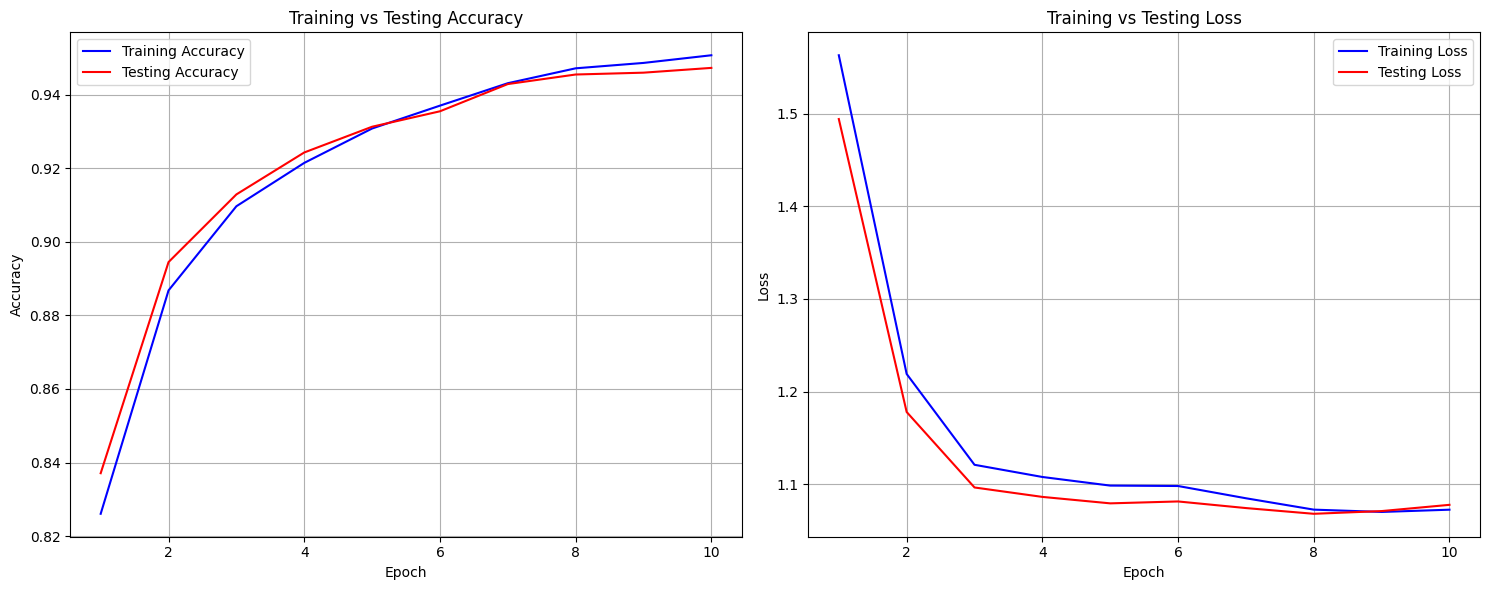

In [15]:
dnn = DNN(sizes=[784, 128, 64, 10], epochs=10, lr=0.1)
dnn.train(train_list, test_list, 10)
plt.show()